In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

## Data Preprocessing

In [2]:
df = pd.read_csv('the-reddit-nft-dataset-comments.csv')

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,2,3,4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#data preprocessing
data_set = df.sample(n=1000000,random_state = 50).dropna().drop(columns=['id','subreddit.id','subreddit.name','subreddit.nsfw','created_utc','type','sentiment','score'])

In [4]:
def remove_dup(string):
    new_string = ""
    prev_string = ""
    for char in string:
        if len(new_string) == 0:
            new_string += char
            prev_string = char
        if char == prev_string:
            continue
        else:
            new_string += char
            prev_string = char
    return new_string

In [5]:
alphanumeric = lambda x: re.sub("[^a-zA-Z0-9 ]",'',x)
http = lambda x: re.sub('http\S+', '',x)
lower_case = lambda x: x.lower()
duplicates = lambda x: remove_dup(x)
all_nums = lambda x: re.sub("\d+", '', x)
nft = lambda x: re.sub("nft\S+",'',x)
discord = lambda x: re.sub("discord\S+",'',x)

In [6]:
data_set['body'] = data_set.body.map(duplicates).map(alphanumeric).map(http).map(all_nums).map(nft).map(discord).map(lower_case)

In [7]:
#create copy of dataset
analysis = data_set.copy()

In [27]:
analysis.shape

(276282, 2)

In [9]:
#add new stop words to the nltk list
cus_stop_words = nltk.corpus.stopwords.words('english')
custom_stop = ['nft','fungible','token','nfts','htps','com','amp','gt','coments','get','go','cointest','fresh','polydroids',
               'twiter','ur','mad','stay','thebevyvip','wil', 'like', 'al', 'people', 'based', 'date', 'gras', 'would', 'one',
              'gras', 'kevin', 'based','fuck','old','sort','nbsp','think', 'please', 'directly', 'showing', 
               'life', 'away', 'start','rnft','join']
cus_stop_words.extend(custom_stop)

In [10]:
len(cus_stop_words)

223

In [11]:
def show_topics(model, feature_names, no_top_words, topic_names=None):
    for x, topic in enumerate(model.components_):
        if not topic_names or not topic_names[x]:
            print("\nTopic ", x)
        else:
            print("\nTopic: '",topic_names[x],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
    return model, feature_names, no_top_words


## Count Vectorizer

In [125]:
vectorizer = CountVectorizer(stop_words=cus_stop_words,
                      max_df=0.6)

terms_vec = vectorizer.fit_transform(analysis.body)

terms_vec.toarray()

terms_vec.shape

(276282, 218995)

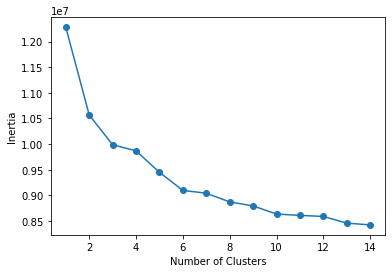

In [126]:
count_inertia = []
count_num_clusters = list(range(1,15))
for x in count_num_clusters:
    km = KMeans(n_clusters=x)
    km.fit(terms_vec)
    count_inertia.append(km.inertia_)
    
plt.plot(count_num_clusters,count_inertia)
plt.scatter(count_num_clusters,count_inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [127]:
vec_df = pd.DataFrame(terms_vec.toarray(), columns=vectorizer.get_feature_names_out())
vec_df

,aa,aaa,aachtchualyi,aachtshualeyh,aada,aadafinancehtpstwitercomaadafinance,aadhar,aaevegotchi,aah,aaiflavored,...,zyngier,zyns,zyori,zytara,zyxwvuhtpswreditcomuserzyxwvu,zyz,zz,zzeung,zzidog,zzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
lsa = TruncatedSVD(10)
lsa.fit(terms_vec)

TruncatedSVD(n_components=10)

In [129]:
vec_topics = show_topics(lsa, vectorizer.get_feature_names_out(), 10)


Topic  0
cum, cumc, cumcum, belgium, taiwan, fortnite, meow, koala, zamn, china



Topic  1
discordhtps, automaticaly, questions, bot, concerns, action, moderators, contact, performed, submision



Topic  2
click, models, make, money, learn, onlyfans, new, bevy, content, sexy



Topic  3
meow, fortnite, taiwan, belgium, koala, china, zamn, femboy, amogus, cat



Topic  4
meow, taiwan, belgium, koala, fortnite, zamn, femboy, china, amogus, models



Topic  5
youre, dont, cant, ratio, cringe, care, yo, sex, bitches, baka



Topic  6
subredit, gme, jan, money, im, everything, even, could, value, thats



Topic  7
subredit, gme, jan, fri, thu, mar, wed, sold, feb, shares



Topic  8
us, live, everything, discusion, buysel, thank, game, discordhtps, share, dont



Topic  9
game, games, subredit, play, earn, jan, gme, playtoearn, gaming, playing




## TFIDF Vectorizer

In [12]:
TFIDF = TfidfVectorizer(stop_words=cus_stop_words,
                      max_df=0.4)

terms_TFIDF = TFIDF.fit_transform(analysis.body)

terms_TFIDF.toarray()

terms_TFIDF.shape

(276282, 218995)

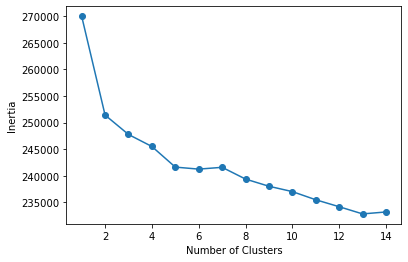

In [50]:
TFIDF_inertia = []
TFIDF_num_clusters = list(range(1,15))
for y in TFIDF_num_clusters:
    km = KMeans(n_clusters=y)
    km.fit(terms_TFIDF)
    TFIDF_inertia.append(km.inertia_)
    
plt.plot(TFIDF_num_clusters,TFIDF_inertia)
plt.scatter(TFIDF_num_clusters,TFIDF_inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [13]:
TFIDF_df = pd.DataFrame(terms_TFIDF.toarray(), columns=TFIDF.get_feature_names_out())
TFIDF_df

,aa,aaa,aachtchualyi,aachtshualeyh,aada,aadafinancehtpstwitercomaadafinance,aadhar,aaevegotchi,aah,aaiflavored,...,zyngier,zyns,zyori,zytara,zyxwvuhtpswreditcomuserzyxwvu,zyz,zz,zzeung,zzidog,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
nmf_model = NMF(10)
nmf = nmf_model.fit_transform(terms_TFIDF)

In [15]:
TFIDF_topics = show_topics(nmf_model, TFIDF.get_feature_names_out(), 10, ['NFT Buy/Sell General Discussion', 'Onlyfans','Moderator Channel','NFT Theft',
                                                                           'Random','Crypto Discussion','NFT Giveaway','NFT Art','Opensea',
                                                                         'Metamask'])




Topic: ' NFT Buy/Sell General Discussion '
discordhtps, buysel, discusion, everything, live, thank, us, share, subreditmesagecomposetornft, submision



Topic: ' Onlyfans '
models, click, onlyfans, learn, bevy, directory, sexy, content, new, money



Topic: ' Moderator Channel '
discords, chanelhtps, fil, contactreditmods, aproved, formhtpsformsgleebzpvoxmnhaxc, alow, removed, doesnt, first



Topic: ' NFT Theft '
luscious, godbye, preparing, strets, stole, ruin, prepare, lawyer, youi, theft



Topic: ' Random '
karma, however, contributions, postcoment, engage, automaticaly, combined, award, wait, ask



Topic: ' Crypto Discussion '
dont, game, im, buy, art, crypto, make, money, know, could



Topic: ' NFT Giveaway '
discord, fre, giveaway, chanel, adres, verify, drop, server, upvote, send



Topic: ' NFT Art '
links, submit, discordhtps, hashtags, coment, title, ad, alow, however, removed



Topic: ' Opensea '
latest, colection, everyonei, herehtpsopenseaiocolectionhelkity, zombie, 

In [28]:
TFIDF_df = pd.DataFrame(nmf.round(5),columns = ['NFT Buy/Sell General Discussion', 'Onlyfans','Moderator Channel','NFT Theft',
                                                                           'Random','Crypto Discussion','NFT Giveaway','NFT Art','Opensea',
                                                                         'Metamask'])
TFIDF_df.shape

(276282, 10)

In [41]:
analysis = analysis.reset_index().drop(columns=['index'])

In [44]:
recommender_df = pd.concat([TFIDF_df,analysis],axis=1)

In [46]:
recommender_df.to_csv('recommender_df')